In [1]:
import os
import pickle
import sys
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import gala.coordinates as gc

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
from tqdm import tqdm, trange
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

from stream_helpers import rots, get_data, apwnorm, get_rot

### Load cubes:

In [2]:
cube, distmods, footprint = get_data(
    '../data/BASS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz', 
    '../data/DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz', 
    stitch=True)

npix, nslice = cube.shape
nside = hp.npix2nside(npix)

In [3]:
pix_idx = np.arange(hp.nside2npix(nside), dtype=int)
pix_c = hp.pix2ang(nside, pix_idx, 
                   lonlat=True)
pix_c = coord.SkyCoord(pix_c[0]*u.deg, pix_c[1]*u.deg)

In [4]:
pix_gal = pix_c.transform_to(coord.Galactic)
pix_l = pix_gal.l
pix_b = pix_gal.b

In [5]:
pix_b_mask = (((np.abs(pix_b) > 20*u.deg) 
               & (np.abs(pix_l - 180*u.deg) < 90*u.deg)) 
              | ((np.abs(pix_b) > 40*u.deg) & (np.abs(pix_l) < 90*u.deg)))

In [6]:
cubesum = np.sum(cube, axis=1)
footprint_mask = cubesum != 0

---

### Known globs and blobs

In [7]:
all_blobs = at.Table.read('/Users/apricewhelan/data/Misc/MW_dwarfs_globs.fits')
all_blobs = all_blobs[all_blobs['DM'] < 25]
all_blobs_c = coord.SkyCoord(all_blobs['ra']*u.deg,
                             all_blobs['dec']*u.deg,
                             coord.Distance(distmod=all_blobs['DM']))

# Special case some half-light radii:
all_blobs['r_h'][all_blobs['name'] == 'SagittariusdSph'] = 2.5 * 60
all_blobs['r_h'][all_blobs['name'] == '#Andromeda'] = 1.5 * 60
all_blobs['r_h'][all_blobs['name'] == 'BootesIII'] = 10
all_blobs['r_h'][all_blobs['name'] == 'LMC'] = 5*60
all_blobs['r_h'][all_blobs['name'] == 'SMC'] = 2.5*60
all_blobs['r_h'][all_blobs['name'] == 'Triangulum'] = 60
all_blobs['r_h'][all_blobs['name'] == 'NGC5904 (M 5)'] /= 2

blobs = at.Table.read('/Users/apricewhelan/data/Misc/Vasiliev-globclust.txt',
                      format='ascii.basic')
blobs.rename_column('Name', 'name')
blobs_c = coord.SkyCoord(blobs['RA']*u.deg,
                         blobs['DEC']*u.deg,
                         blobs['D']*u.kpc)

In [8]:
in_footprint_idx = []
for i, cl_c in enumerate(blobs_c):
    pix = hp.ang2pix(nside, cl_c.ra.degree, cl_c.dec.degree, 
                     lonlat=True)
    
    if footprint_mask[pix]:
        in_footprint_idx.append(True)
    else:
        in_footprint_idx.append(False)
        
in_footprint_idx = np.array(in_footprint_idx)

In [9]:
len(blobs[in_footprint_idx])

25

### Come up with a mask for bright galaxies and globular clusters

In [10]:
this_blob_mask = np.ones(hp.nside2npix(nside))
for row, cc in zip(all_blobs, all_blobs_c):        
    size = (cc.distance * row['r_h']*u.arcmin).to_value(u.kpc, u.dimensionless_angles())
    rep = coord.CartesianRepresentation(np.random.normal(cc.cartesian.xyz.to_value(u.kpc), 
                                                         2 * size, 
                                                         (65536, 3)).T * u.kpc)
    spray = coord.SkyCoord(rep)
    this_blob_mask[hp.ang2pix(nside, spray.ra.degree, spray.dec.degree, lonlat=True)] = 0.
    
# Also mask out Sag:
# mask_c = gc.Sagittarius(np.random.uniform(0, 360, 4*65536)*u.deg,
#                         np.random.normal(0, 10, 4*65536)*u.deg).transform_to(coord.ICRS)
# this_blob_mask[hp.ang2pix(nside, mask_c.ra.degree, mask_c.dec.degree, lonlat=True)] = 0.
    
this_blob_mask = hp.smoothing(this_blob_mask, sigma=np.radians(0.2))
_derp = this_blob_mask > 0.8
this_blob_mask[_derp] = 1
this_blob_mask[~_derp] = 0
blob_mask = np.array(1 - this_blob_mask, dtype=bool)

full_stack = np.sum(cube, axis=1) / nslice
full_stack_masked = full_stack * this_blob_mask
full_stack_masked[full_stack_masked > 1e3] = 0.

Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### Images in different projections

In [12]:
slices = [(26, 55),
          (15, 26),
          (5, 15)]

slice_str = '_'.join(['{}-{}'.format(x,y) for x,y in slices])
dist = coord.Distance(distmod=distmods)

for x, y in slices:
    print(dist[x], dist[y])

20.892961308540322 kpc 79.43282347242742 kpc
12.589254117941637 kpc 20.892961308540322 kpc
7.943282347242814 kpc 12.589254117941637 kpc


In [35]:
stacks = np.stack([np.sum(cube[:, x:y], axis=1) / (y - x) 
                   for x, y in slices], 
                  axis=-1)

rgb = np.zeros_like(stacks)
for i in range(3):
    X = stacks[..., i]

    # No bg subtrack:
    rgb[..., i] = hp.smoothing(X, sigma=np.radians(0.17), verbose=False)
    
    # Subtract smoothed
    # Xnoblob = X.copy()
    # Xnoblob[blob_mask] = 0.
    # rgb[..., i] = (hp.smoothing(X, sigma=np.radians(0.15)) - 
    #                hp.smoothing(Xnoblob, sigma=np.radians(7.5)))
    
    # Subtract crazy-ass background model from above
    # rgb[..., i] = X - bg_model
    # rgb[..., i] = X - get_bg(X)
    # rgb[..., i] = hp.smoothing(rgb[..., i], sigma=np.radians(0.2))
    
    rgb[X==0, i] = 0.

for i in range(3):
    X = stacks[..., i]
    
    rgb[..., i] = apwnorm(rgb[..., i], 
                          min=np.percentile(rgb[footprint, i], 2.5), #2.5), 
                          max=np.percentile(rgb[footprint, i], 92))
    
    rgb[X==0, i] = 0.

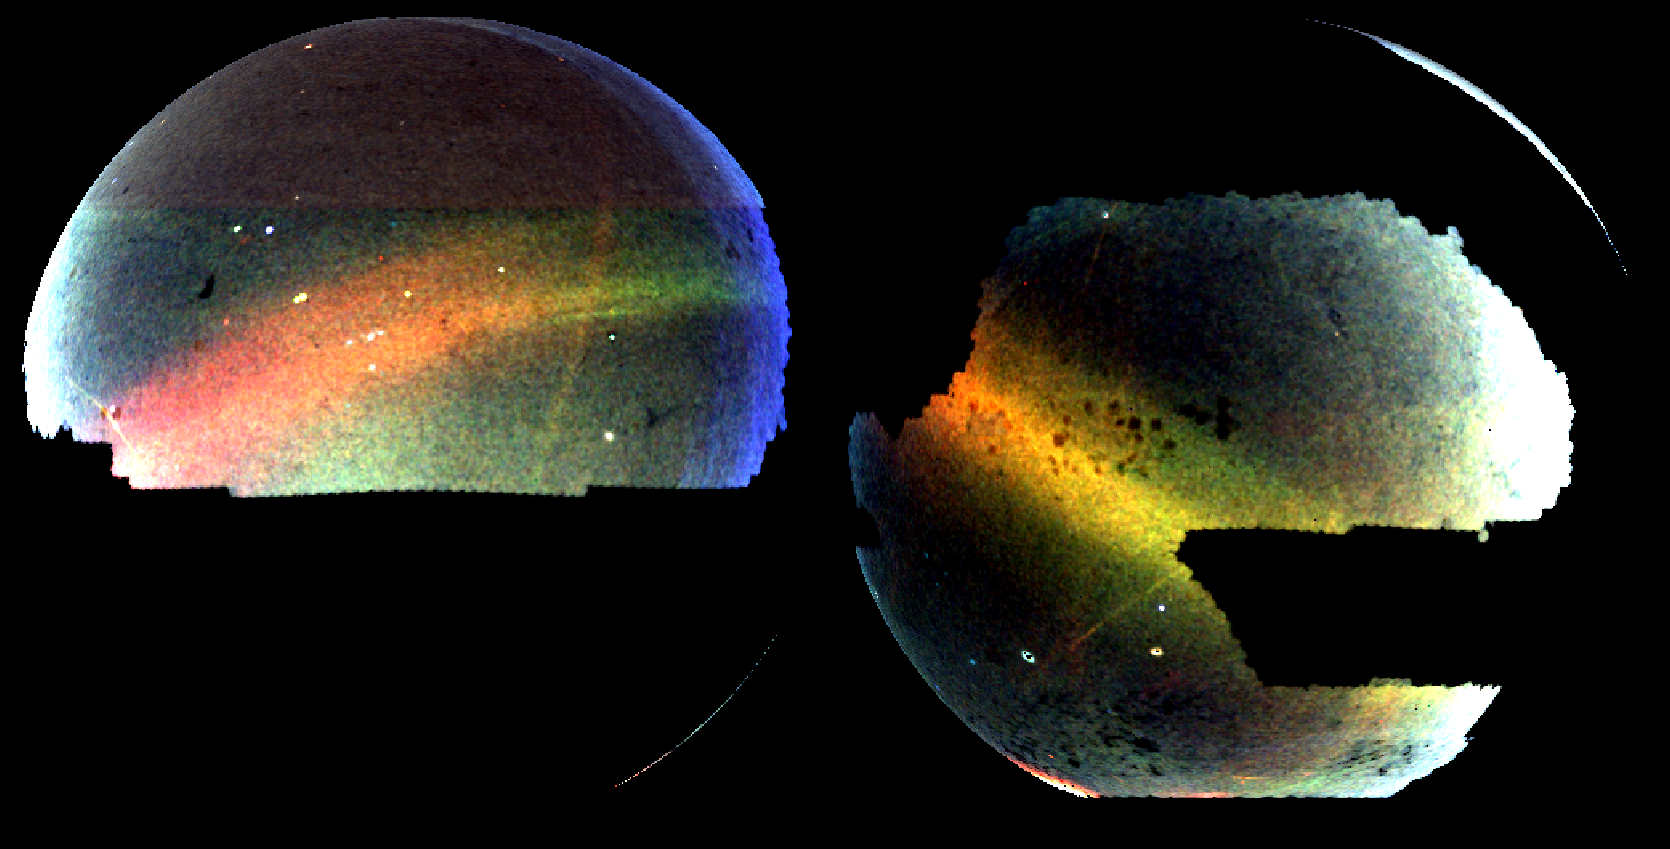

In [37]:
proj = hp.projector.OrthographicProj(xsize=1024, half_sky=False, rot=[180, 0])

fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
img = np.stack([proj.projmap(rgb[:, i], func) 
                for i in range(3)], axis=-1)
H = ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for k, s in ax.spines.items():
    s.set_visible(False)
fig.tight_layout()
fig.set_facecolor('k')

In [38]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [39]:
nframes = 512
angs = np.stack((
    np.linspace(0, 2 * 360, nframes),
    40 * np.sin(2*np.pi*np.arange(nframes) / nframes)
)).T

# np.concatenate((np.linspace(0, 30, 64),
#                     np.linspace(30, -30, 128),
#                     np.linspace(-30, 0, 64)))

angs.shape

(512, 2)

In [40]:
rots = []
for a, b in angs:
    rot = (np.array([a, b, 0])) % 360
    rots.append(rot)
len(rots)

512

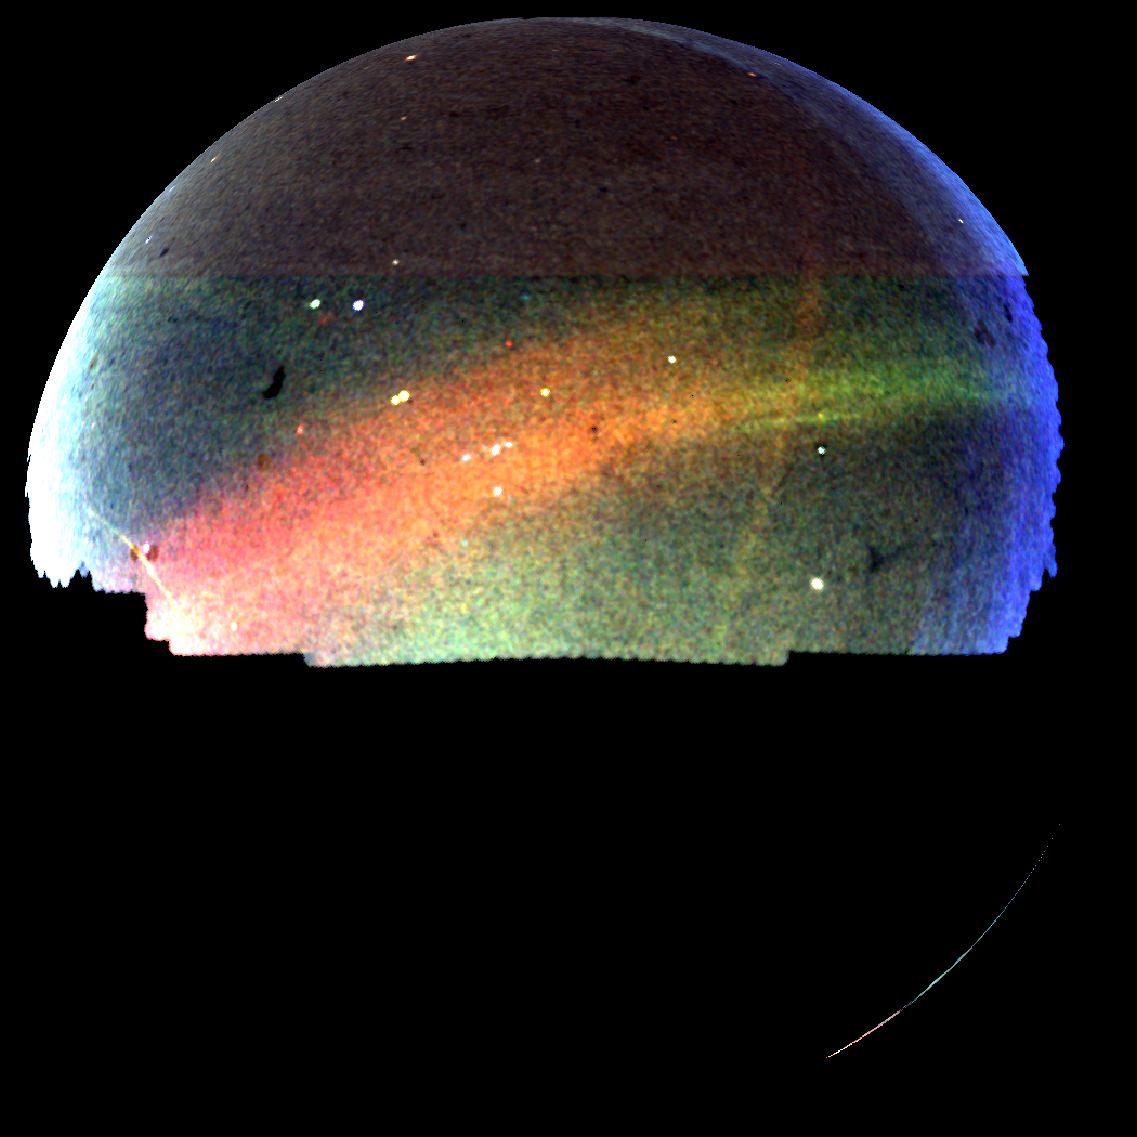

In [44]:
proj = hp.projector.OrthographicProj(xsize=1024, half_sky=True,
                                     rot=[180, 0, 0])
# proj = hp.projector.OrthographicProj(xsize=1024, half_sky=True,
#                                      rot=[266.40498829, -28.93617776, 59.])

fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)

img = np.stack([proj.projmap(rgb[:, i], func, rot=[0, 0., 45]) 
                for i in range(3)], axis=-1)
H = ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for k, s in ax.spines.items():
    s.set_visible(False)
fig.tight_layout()
fig.set_facecolor('k')

def init(*args):
    H.set_array(img)
    return H,

def animate(j):
    img = np.stack([proj.projmap(rgb[:, i], func, rot=rots[j]) 
                    for i in range(3)], axis=-1)
    H.set_array(img)
    return H,
    
anim = FuncAnimation(fig, animate, frames=np.arange(len(rots)), 
                     blit=True, interval=60)

In [45]:
# HTML(anim.to_html5_video())

In [46]:
anim.save("../plots/fieldofstreams/rotate.mp4", dpi=250, 
          savefig_kwargs={'facecolor':'k'})

In [140]:
anim.save("../plots/fieldofstreams/rotate.gif", dpi=250, 
          savefig_kwargs={'facecolor':'k'},
          writer=mpl.animation.PillowWriter())